# Analyze sea-level predictions for Greenland by ISMIP6 and Aschwanden et al (2019) [AS19]

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import os
import pylab as plt
import pandas as pd
import seaborn as sns
import scipy

import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors

from utilities.data_loader import load_imbie_gris, load_ismip6_gris, load_imbie_ais, load_ismip6_ais
from utilities.helper import hist_start, hist_end, proj_start, proj_end, proj_time, secpera, ais_exp_dict

import warnings
warnings.filterwarnings('ignore')

## Plotting helpers

In [3]:
fontsize = 8
lw = 0.65
aspect_ratio = 0.35
markersize = 2

params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


grace_signal_lw = 0.75
mouginot_signal_lw = 0.75
imbie_signal_lw = 0.75
simulated_signal_lw = 0.15
imbie_signal_color = "#005a32"
imbie_sigma_color = "#a1d99b"
imbie_sigma_colors = ["#edf8e9", "#bae4b3", "#74c476"]

simulated_signal_color = "0.7"

gt2cmSLE = 1.0 / 362.5 / 10.0

rcp_list = [26, 85]
rcp_dict = {26: "RCP 2.6", 45: "RCP 4.5", 85: "RCP 8.5"}
rcp_col_dict = {85: "#990002", 45: "#5492CD", 26: "#003466"}
rcp_shade_col_dict = {85: "#F4A582", 45: "#92C5DE", 26: "#4393C3"}
model_ls_dict = {"Model Uncertainty (ISMIP6)": "solid", "Parametric Uncertainty (AS19)": "dashed"}


def set_size(w, h, ax=None):
    """ w, h: width, height in inches """

    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)



## Load ISMIP6 projections

In [14]:
ismip6_ais = load_ismip6_ais(remove_ctrl=False)
ismip6_gris = load_ismip6_gris(remove_ctrl=False)
ismip6_ais["IS"] = "AIS"
ismip6_gris["IS"] = "GRIS"
ismip6 = pd.concat([ismip6_ais, ismip6_gris])
ismip6_ais_ctrl_removed = load_ismip6_ais(remove_ctrl=True)
ismip6_gris_ctrl_removed = load_ismip6_gris(remove_ctrl=True)
ismip6_ais_ctrl_removed["IS"] = "AIS"
ismip6_gris_ctrl_removed["IS"] = "GRIS"
ismip6_ctrl_removed = pd.concat([ismip6_ais_ctrl_removed, ismip6_gris_ctrl_removed])

ismip6_gris_ctrl_removed.csv.gz not found locally. Downloading the ISMIP6 archive.
   ...and converting to CSV
ismip6_gris_ctrl_removed.csv.gz


## ISMIP6 in numbers

In [15]:
ng = len(ismip6_ais.groupby(by="Group").mean())
nm = len(ismip6_ais.groupby(by="Model").mean())
ne = len(ismip6_ais.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

ng = len(ismip6_gris.groupby(by="Group").mean())
nm = len(ismip6_gris.groupby(by="Model").mean())
ne = len(ismip6_gris.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

Number of modeling groups participated: 13
Number of ice sheet model configurations used: 14
Number of experiments: 21
Number of modeling groups participated: 13
Number of ice sheet model configurations used: 18
Number of experiments: 9


## Load Observations

In [16]:
imbie_ais = load_imbie_ais()
imbie_gris = load_imbie_gris()
imbie_ais["IS"] = "AIS"
imbie_gris["IS"] = "GRIS"
imbie = pd.concat([imbie_ais, imbie_gris])

## Plot function to reproduce Figure 1 in Aschwanden et al (2021)

In [19]:
def plot_historical(
    out_filename, ismip6, observed, x_lim=[2000, 2025], p_var="Cumulative ice sheet mass change", p_units="Gt"
):
    """
    Plot historical simulations and observations.
    """

    plot_var = f"{p_var} ({p_units})"
    def plot_signal(g, ax):
        m_df = g[-1]
        x = m_df["Year"]
        y = m_df[plot_var]
        return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)

    fig, axs = plt.subplots(2, 1, sharex="col", figsize=[5.2, 4.25])
    fig.subplots_adjust(hspace=0.1, wspace=0.25)
    
    y_lim = np.array([[-20000, -3000], [15000, 5000]])

    for k, ice_sheet in enumerate(["AIS", "GRIS"]):

        df = ismip6[ismip6["IS"] == ice_sheet]
        imbie = observed[observed["IS"] == ice_sheet]

        [plot_signal(g, axs[k]) for g in df.groupby(by=["Group", "Model", "Exp"])]

        ismip6_mean = df.groupby(by="Year")[plot_var].mean().dropna()
        ismip6_low = df.groupby(by="Year")[plot_var].quantile(0.05).dropna()
        ismip6_high = df.groupby(by="Year")[plot_var].quantile(0.95).dropna()

        ismip6_ci = axs[k].fill_between(
            ismip6_mean.index,
            ismip6_low,
            ismip6_high,
            color="0.0",
            alpha=0.30,
            linewidth=0.0,
            zorder=10,
            label="90% c.i. (ISMIP6) ",
        )

        imbie_cis = []
        for s, sigma in enumerate([2, 1]):
            imbie_ci = axs[k].fill_between(
                imbie["Year"],
                imbie[plot_var] - sigma * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
                imbie[plot_var] + sigma * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
                color=imbie_sigma_colors[s],
                alpha=0.5,
                linewidth=0,
                label=f"{sigma}-sigma (IMBIE)"
            )
            imbie_cis.append(imbie_ci)

        imbie_line = axs[k].plot(
            imbie["Year"],
            imbie[plot_var],
            "-",
            color=imbie_signal_color,
            linewidth=imbie_signal_lw,
            label="Observed (IMBIE)",
        )

        axs[k].axvline(proj_start, color="k", linestyle="dashed", linewidth=grace_signal_lw)
        axs[k].axhline(0, color="k", linestyle="dotted", linewidth=grace_signal_lw)

        axs[k].set_xlim(x_lim[0], x_lim[1])
        axs[k].set_ylim(y_lim[0, k], y_lim[1, k])
        ax_sle = axs[k].twinx()
        ax_sle.set_ylabel(f"Contribution to sea-level \nsince {proj_start} (cm SLE)")
        ax_sle.set_ylim(-y_lim[0, k] * gt2cmSLE, -y_lim[1, k] * gt2cmSLE)
        axs[k].set_ylabel(f"{p_var}\nsince {proj_start} ({p_units})")
        axs[k].text(0.025, 0.90, ice_sheet, ha="left", weight="bold", transform=axs[k].transAxes)



    model_line = mlines.Line2D(
        [], [], color=simulated_signal_color, linewidth=simulated_signal_lw, label="Simulated (ISMIP6)"
    )

    axs[0].text(0.59, 0.90, "Historical Period", ha="right", transform=axs[0].transAxes)
    axs[0].text(0.61, 0.90, "Projection Period", ha="left", transform=axs[0].transAxes)


    legend = axs[1].legend(handles=[imbie_line[0], *imbie_cis, model_line, ismip6_ci], loc="upper right")
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)


    axs[1].set_xlabel("Year")


    fig.savefig(out_filename, bbox_inches="tight")


## Plot the historical simulations along side observations

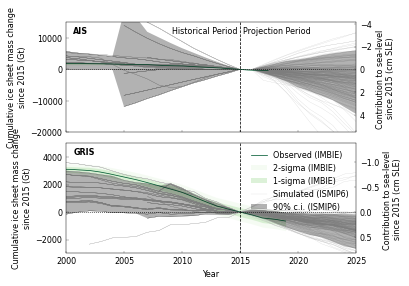

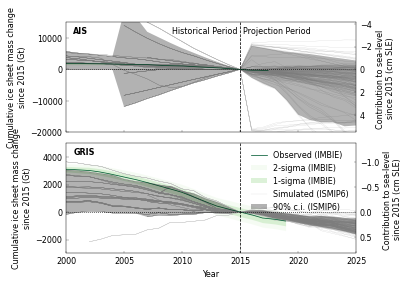

In [20]:
historical_filename = "IS_historical.pdf"
plot_historical(historical_filename, ismip6, imbie)
historical_filename = "IS_historical_ctrl_removed.pdf"
plot_historical(historical_filename, ismip6_ctrl_removed, imbie)

## Comparison between model and parametric uncertainty

Below we plot each group's contribution for AIS.

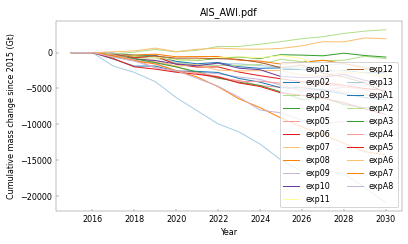

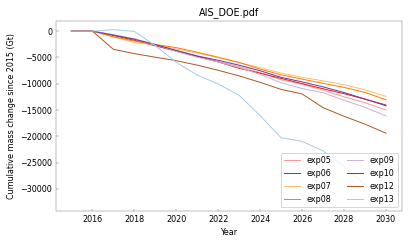

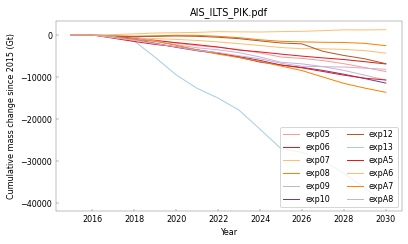

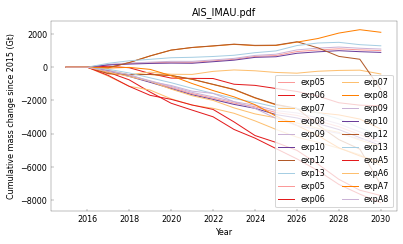

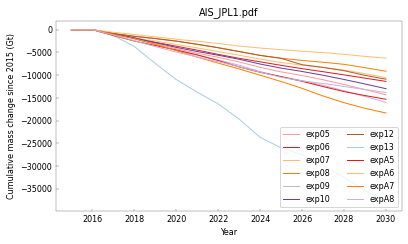

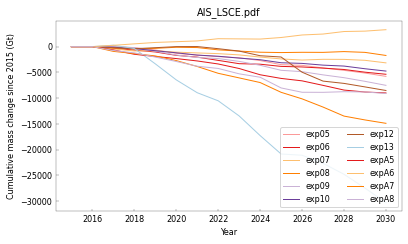

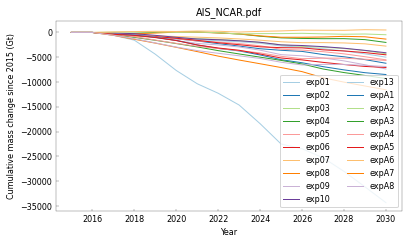

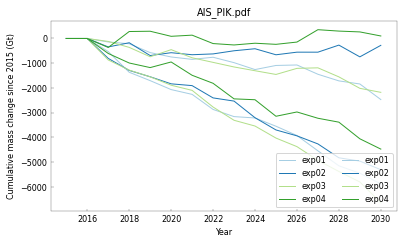

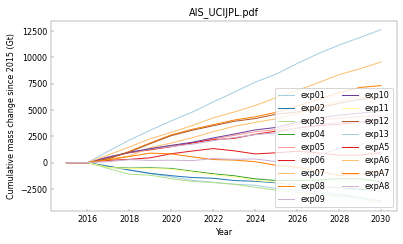

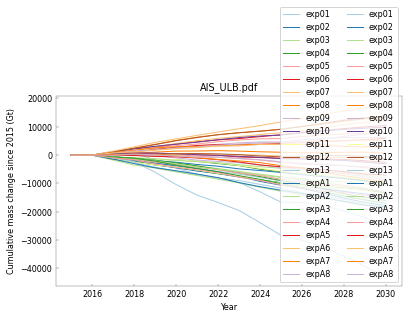

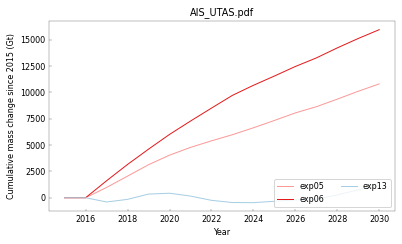

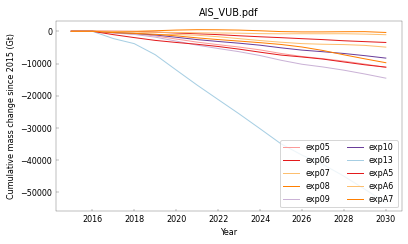

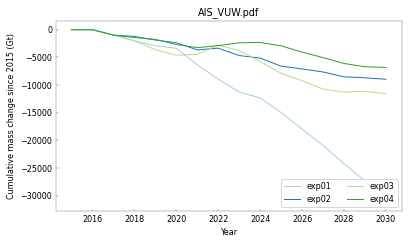

In [9]:
exp_color_dict = dict(zip(ais_exp_dict.keys(), sns.color_palette("Paired", len(ais_exp_dict)).as_hex()))


def plot_signal(g, ax):
    m_df = g[-1]
    x = m_df["Year"]
    y = m_df["Cumulative ice sheet mass change (Gt)"]
    exp = m_df["Exp"].values[0]
    return ax.plot(x, y, color=exp_color_dict[exp], linewidth=1.0, label=exp)


for ice_sheet in ["AIS"]:
    is_df = ismip6[(ismip6["IS"] == ice_sheet)]
    groups = is_df["Group"].unique()
    for group in groups:
        df = is_df[(is_df["Group"] == group) & (is_df["Year"] >= proj_start) & (is_df["Year"] <= 2030)]
        fig = plt.figure(figsize=[6.2, 3.5])
        ax = fig.add_subplot(111)
        [plot_signal(g, ax) for g in df.groupby(by=["Model", "Exp"])]
        ax.set_xlabel("Year")
        ax.set_ylabel("Cumulative mass change since 2015 (Gt)")
        plt.legend(loc="lower right", ncol=2)
        plt.title(f"{ice_sheet}_{group}.pdf")
        fig.savefig(f"{ice_sheet}_{group}.pdf")
        


In [10]:
from utilities.data_loader import ismip6_gris_to_csv

In [11]:
ismip6_gris_to_csv?

In [12]:
ismip6_ais[ismip6_ais["Year"] > 2014]

,Unnamed: 0,Year,Cumulative ice sheet mass change (Gt),Group,Model,Exp,RCP,Rate of surface mass balance anomaly (Gt/yr),Rate of ice sheet mass change (Gt/yr),IS
9,9,2015.0,0.000000,AWI,PISM1,exp01,85,NaN,-329.284410,AIS
10,0,2016.0,0.000000,AWI,PISM1,exp01,85,NaN,-93.802086,AIS
11,1,2017.0,-187.604171,AWI,PISM1,exp01,85,NaN,-326.353091,AIS
12,2,2018.0,-652.706181,AWI,PISM1,exp01,85,NaN,-160.245231,AIS
13,3,2019.0,-508.094632,AWI,PISM1,exp01,85,NaN,-325.375987,AIS
...,...,...,...,...,...,...,...,...,...,...
39306,81,2096.5,NaN,VUW,PISM,exp04,85,760.018772,NaN,AIS
39307,82,2097.5,NaN,VUW,PISM,exp04,85,510.758945,NaN,AIS
39308,83,2098.5,NaN,VUW,PISM,exp04,85,502.004801,NaN,AIS
39309,84,2099.5,NaN,VUW,PISM,exp04,85,758.866566,NaN,AIS
